In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.tree import plot_tree
import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [26]:
data=pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [27]:
print(data['Sleep Disorder'].unique())

[nan 'Sleep Apnea' 'Insomnia']


In [28]:
data['Sleep Disorder'] = data['Sleep Disorder'].map({'Sleep Apnea': 1, 'Insomnia': 2})
data['Sleep Disorder'] = data['Sleep Disorder'].fillna(0)
print(data['Sleep Disorder'].head())

0    0.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: Sleep Disorder, dtype: float64


In [29]:
le = LabelEncoder()
data['Occupation'] = le.fit_transform(data['Occupation'])
print(data['Occupation'].head())

0    9
1    1
2    1
3    6
4    6
Name: Occupation, dtype: int64


In [30]:
le = LabelEncoder()
data['BMI Category']=le.fit_transform(data['BMI Category'])
data['Gender']=le.fit_transform(data['Gender'])
print(data['BMI Category'])

0      3
1      0
2      0
3      2
4      2
      ..
369    3
370    3
371    3
372    3
373    3
Name: BMI Category, Length: 374, dtype: int64


In [31]:
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True)
data['Systolic'] = pd.to_numeric(data['Systolic'])
data['Diastolic'] = pd.to_numeric(data['Diastolic'])
data = data.drop('Blood Pressure', axis=1)
print(data[['Systolic', 'Diastolic']].head())

   Systolic  Diastolic
0       126         83
1       125         80
2       125         80
3       140         90
4       140         90


In [32]:
features = data.columns.tolist()
print(features)

['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Sleep Disorder', 'Systolic', 'Diastolic']


In [33]:
features=data.drop('Sleep Disorder',axis=1)
print(features.head())
X = features
y = data['Sleep Disorder']

   Person ID  Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0          1       1   27           9             6.1                 6   
1          2       1   28           1             6.2                 6   
2          3       1   28           1             6.2                 6   
3          4       1   28           6             5.9                 4   
4          5       1   28           6             5.9                 4   

   Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                       42             6             3          77   
1                       60             8             0          75   
2                       60             8             0          75   
3                       30             8             2          85   
4                       30             8             2          85   

   Daily Steps  Systolic  Diastolic  
0         4200       126         83  
1        10000       125         80  
2        10000

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [35]:
sm=SMOTE(random_state=42)
X_res,y_res=sm.fit_resample(X_train,y_train)

In [52]:
param_grid={
    
    'max_depth':[1,4],
    'min_samples_split':[3,5],
    'min_samples_leaf':[1,2] 
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_res, y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 4], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [3, 5]},
             scoring='accuracy')

In [53]:
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [54]:
final_params = {
    **best_params,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'random_state': 42,
}

In [55]:
final_model =DecisionTreeClassifier(**final_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [56]:
confusionmatrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
report=classification_report(y_test,y_pred,target_names=['0','1','2'])
print(f"Accuracy: {accuracy:.4f}")
print("confusion matrix:\n",confusionmatrix)
print("Classification Report:\n", report)

Accuracy: 0.9204
confusion matrix:
 [[64  1  1]
 [ 2 22  0]
 [ 4  1 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.92      0.92      0.92        24
           2       0.95      0.78      0.86        23

    accuracy                           0.92       113
   macro avg       0.93      0.89      0.90       113
weighted avg       0.92      0.92      0.92       113



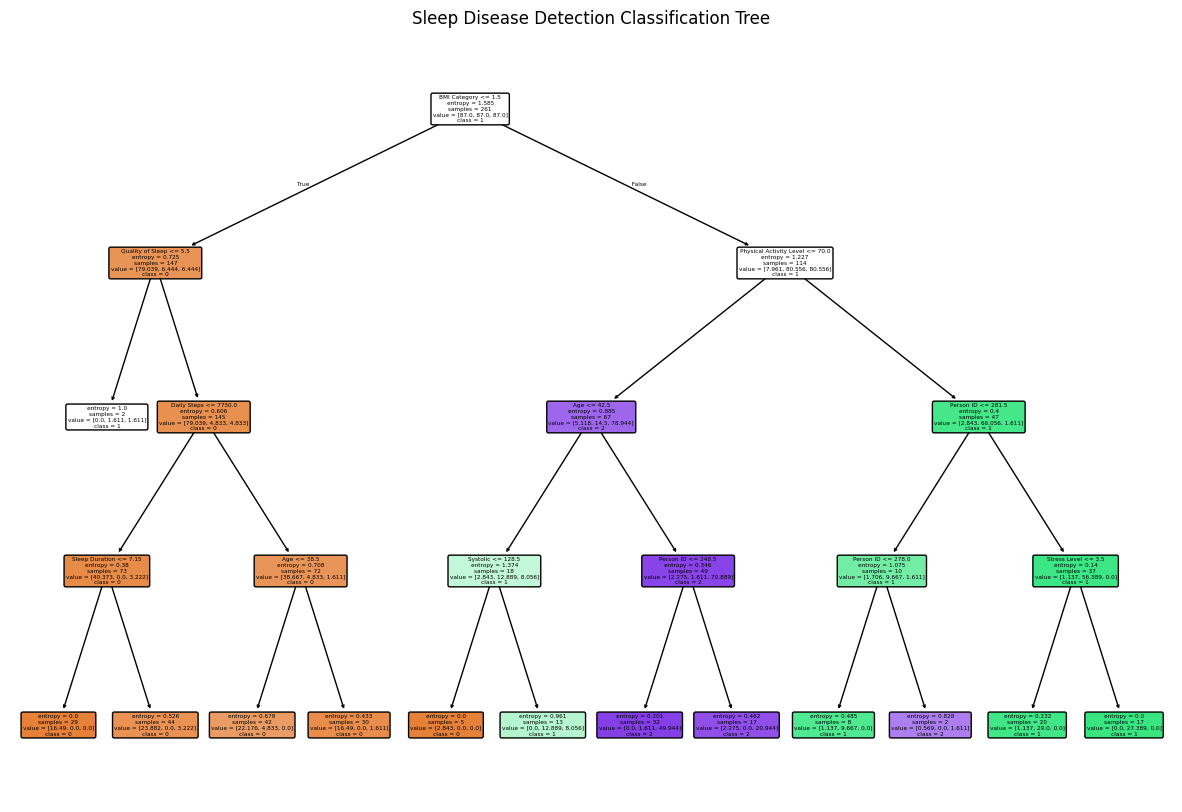

In [58]:
plt.figure(figsize=(15, 10))
plot_tree(final_model,
          feature_names=features.columns.tolist(), 
          class_names=['0', '1', '2'],  
          filled=True,
          rounded=True)

plt.title('Sleep Disease Detection Classification Tree')
plt.show()


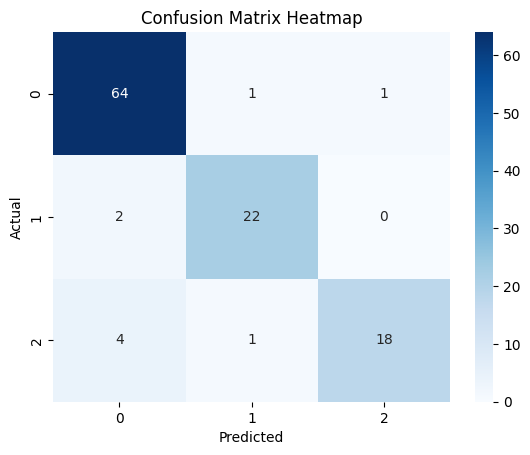

In [59]:
sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0','1','2'], yticklabels=['0','1','2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

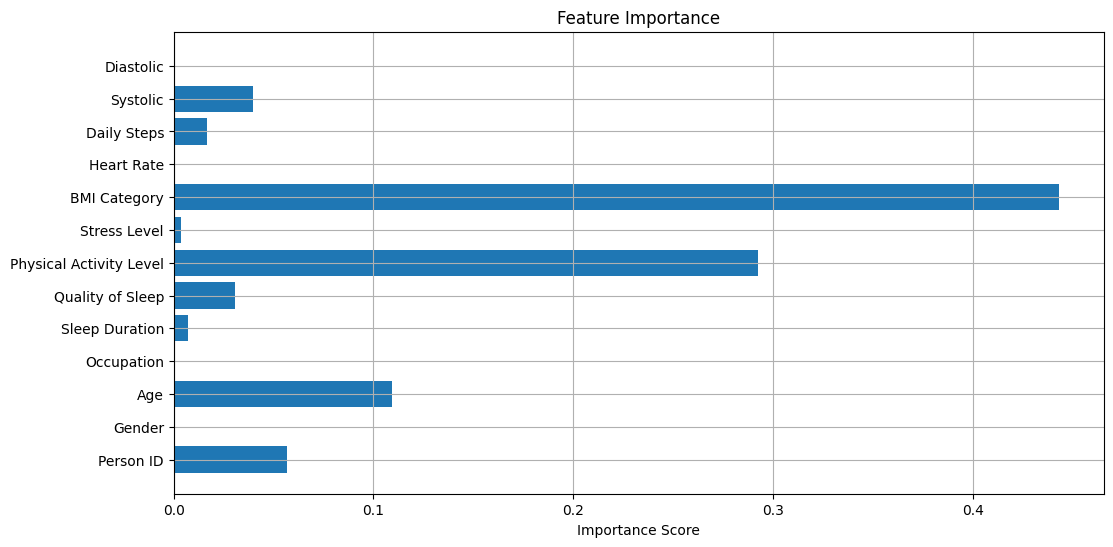

In [61]:
importances = final_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(X.columns, importances)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()